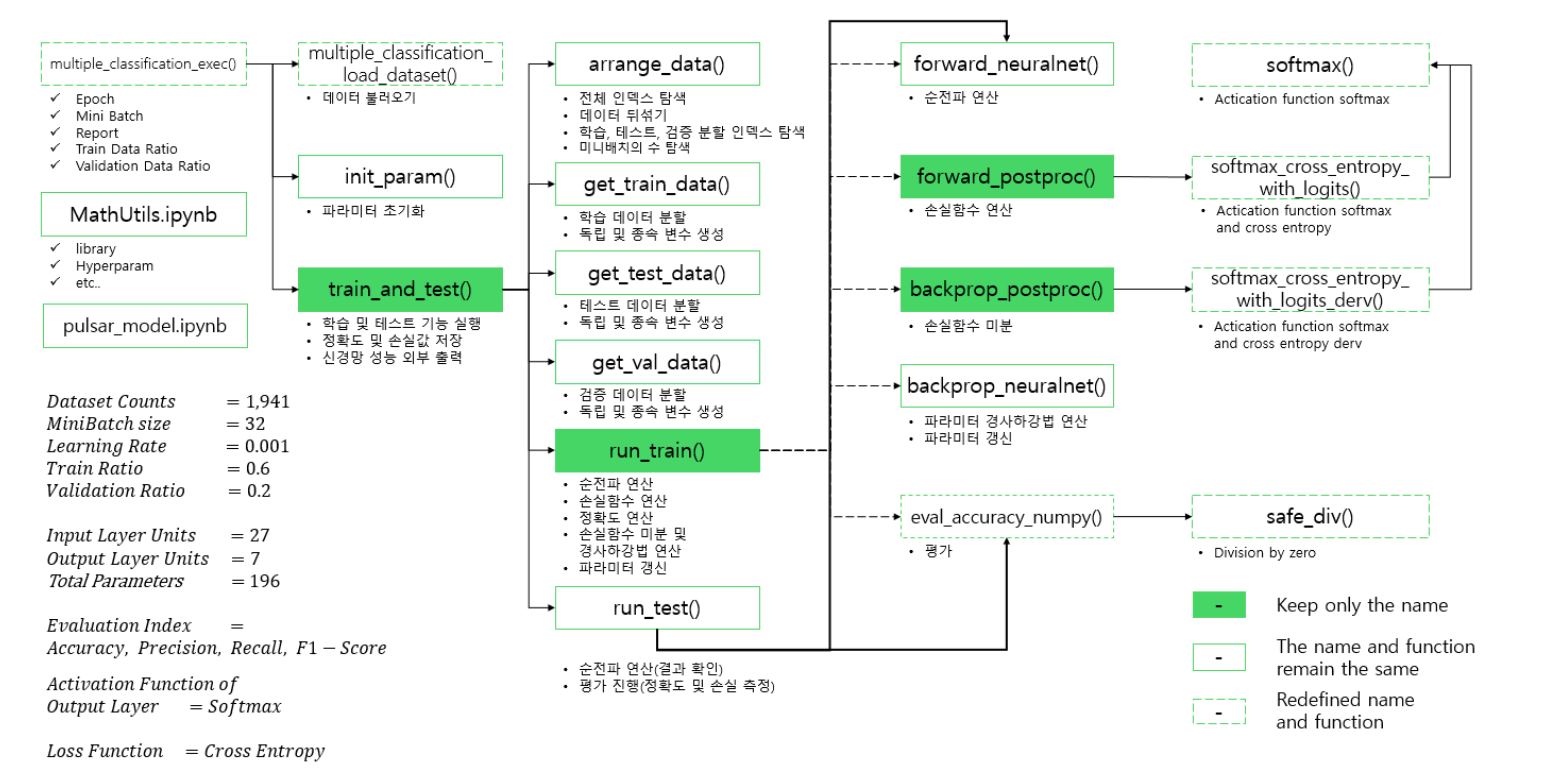

In [1]:
%run /content/MathUtils.ipynb
%run /content/pulsar_model.ipynb

In [2]:
def multiple_classification_exec(epoch_count = 10, mb_size = 10, report = 1, train_ratio = 0.6, val_ratio = 0.2):
    multiple_classification_load_dataset()
    init_param()
    train_metrics_mean_row, val_metrics_row, test_metrics = train_and_test(epoch_count, 
                                                                                mb_size, 
                                                                                report, 
                                                                                train_ratio,
                                                                                val_ratio)
    return train_metrics_mean_row, val_metrics_row, test_metrics

In [6]:
def multiple_classification_load_dataset():
    with open('/content/faults.csv') as csvfile:
    #with open('/content/faults_mini.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        rows = []
        for row in csvreader:
            rows.append(row)

    global data, input_cnt, output_cnt

    input_cnt, output_cnt = 27, 7
    data = np.asarray(rows, dtype='float32')

In [7]:
multiple_classification_load_dataset()
print("data.shape : ", data.shape)

data.shape :  (1941, 34)


In [8]:
def init_param():
    global weight, bias

    weight = np.random.normal(RND_MEAN, RND_STD, size = [input_cnt, output_cnt])
    bias   = np.zeros([output_cnt])      

    print("Initial weight Value : \n{}".format(weight))
    print("Initial bias Value : \n{}".format(bias))

In [9]:
init_param()

Initial weight Value : 
[[-5.61279904e-03  2.64065064e-02 -4.75315883e-02  1.40542290e-02
   6.20183937e-02  1.10542447e-03  7.77446675e-03]
 [-2.66746539e-02 -1.01073013e-02  3.11341722e-02 -5.81694636e-04
   2.11828529e-02 -7.25073988e-03  2.06014315e-02]
 [-1.44672092e-02  5.69698416e-04  4.71592310e-02  4.41958425e-02
  -2.85863612e-02 -2.39315032e-02 -4.24672546e-02]
 [-1.24275880e-02 -1.13268257e-02 -6.78924649e-02 -1.64302880e-02
  -3.14831185e-02  1.48800981e-03 -3.86827811e-02]
 [-1.96717159e-02 -5.05245196e-02 -9.34683730e-03  3.62032466e-02
  -1.98623966e-02 -1.06167289e-02  2.90874583e-02]
 [ 1.41387323e-02  8.40848715e-03 -6.53293970e-02 -6.77417225e-03
  -2.19004608e-02 -1.86157602e-02 -3.20639676e-03]
 [-1.03769678e-02 -6.33001175e-03  1.31021178e-02 -4.51644213e-03
   1.97280097e-02  3.26264524e-02  2.17609302e-02]
 [-2.61091991e-02  7.89312810e-02  7.08179339e-03  2.29621055e-02
  -2.61615583e-02  2.17691772e-02  4.64859350e-02]
 [ 3.22664078e-02  1.39636137e-02 -1.643

In [10]:
def arrange_data(mb_size, train_ratio, val_ratio):

    global shuffle_map, test_begin_index, val_begin_index

    shuffle_map = np.arange(data.shape[0])

    np.random.shuffle(shuffle_map)
    mini_batch_step_count = int(data.shape[0] * train_ratio) // mb_size

    val_begin_index  = mini_batch_step_count * mb_size
    test_begin_index = int(val_begin_index + (val_ratio * data.shape[0]))
    
    return mini_batch_step_count    

In [11]:
mini_batch_step_count = arrange_data(mb_size = 6, train_ratio = 0.6, val_ratio = 0.2)
print("mini_batch_step_count : ", mini_batch_step_count)

mini_batch_step_count :  194


In [12]:
def get_test_data():
    test_data = data[shuffle_map[test_begin_index : ]]
    return test_data[:,:-output_cnt], test_data[:,-output_cnt:]

def get_val_data():
    val_data = data[shuffle_map[val_begin_index : test_begin_index]]
    return val_data[:,:-output_cnt], val_data[:,-output_cnt:]

def get_train_data(mb_size, n):
    from_idx = n * mb_size
    to_idx   = (n + 1) * mb_size

    train_data = data[shuffle_map[from_idx : to_idx]]
    
    return train_data[:,:-output_cnt], train_data[:,-output_cnt:]

In [13]:
train_x, train_y = get_train_data(mb_size = 3, n = 0)
test_x, test_y   = get_test_data()
val_x, val_y     = get_val_data()

In [14]:
def train_and_test(epoch_count, mb_size, report, train_ratio, val_ratio):

    mini_batch_step_count = arrange_data(mb_size,train_ratio, val_ratio)

    test_x, test_y = get_test_data()
    val_x,  val_y  = get_val_data()

    losses_mean_row = []
    val_loss_row    = []

    #losses_mean_row, accs_mean_row = [], []
    #val_loss_row, val_acc_row      = [], []
    
    for epoch in range(epoch_count):

        losses = []
        #accs = []

        for n in range(mini_batch_step_count):
            train_x, train_y  = get_train_data(mb_size, n)
           
            loss, _           = run_train(train_x,train_y)
               
            losses.append(loss)
            #accs.append(acc)

        val_loss, val_acc = run_test(val_x, val_y)
        val_loss_row.append(val_loss)
        #val_acc_row.append(val_acc)  

        if report > 0 and (epoch+1) % report == 0:
            
            print("Epoch {} : Train - Loss = {:.3f} / Val - Loss = {:.3f}, Acc = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}".\
                  format(epoch+1, np.mean(losses), val_loss, val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
            
        losses_mean = np.mean(losses) 
        #accs_mean = np.mean(accs)

        losses_mean_row.append(losses_mean)  
        #accs_mean_row.append(accs_mean)   



    test_loss, test_acc = run_test(test_x, test_y)
    
    print("\n","=" * 50, 'Final Test', '=' * 50)
    print('\nTest Acc = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.\
          format(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
    print('\nLoss = {:.3f}'.format(test_loss))

    #return [losses_mean_row, accs_mean_row], [val_loss_row, val_acc_row], [test_loss , test_acc]
    return [losses_mean_row], [val_loss_row], [test_loss , test_acc]

In [15]:
def forward_neuralnet(x):
    y_hat = np.matmul(x, weight) + bias
    return y_hat, x

In [16]:
y_hat, _ = forward_neuralnet(train_x)
print("y_hat.shape : \n", y_hat.shape)
print("y_hat : \n", y_hat)

y_hat.shape : 
 (3, 7)
y_hat : 
 [[  -9911.25970568   -3566.27444223   -7539.76400313   10206.53339111
   -21939.54980654   -8053.35131326  -29222.40950969]
 [ -37117.60410761  -14370.90707908  -28491.44779275   38289.77601498
   -82661.50729616  -30719.1168335  -111199.43814246]
 [  -6827.76526454    -997.39567646   -4745.26728779    6942.15353606
   -14500.43239477   -4800.23076338  -17939.05181973]]


In [17]:
# softmax() 개선식 구축 과정 
# softmax()가 받는 x값은 신경망의 출력 결괏값
# x == y_hat
def softmax(x):
    # 1. 신경망의 출력 결괏값(※ y(y_hat) = xw + b) 중에서 가장 큰 값을 찾는다. 
    # axis = np.max()는 행과 열을 전부 하나로 합쳐주기에, 
    # x축의 값들만 더해주도록 axis = 1 의 파라미터를 설정(1 → x축)
    max_elem = np.max(x, axis = 1)

    # 2. 신경망의 출력 결괏값(y_hat)들과 신경망 출력 결괏값 중 가장 큰 값(max_elem)의 편차를 구한다. 
    # 첫 번째 transpose()(행렬전환) 붙은 이유는 shape 값이 맞지 않기 때문에 연산이 불가능해서 행렬전환 수행.
    # 두 번째 transpose() 붙은 이유는 다시 원상태의 shape 값으로 만들어 주기 위해서.
    # (3,7) -> transpose() -> (7,3) -> 편차 연산 -> transpose() -> (3,7)
    diff     = (x.transpose() - max_elem).transpose()

    # 3. 2번에서 구한 결괏값을 자연상수 e의 지수로 할당시켜주는 과정
    # 이 과정을 통해 얻은 결괏값은 softmax() 함수를 구축하기 위한 모든 요소값.
    exp      = np.exp(diff)

    # 4. softmax()의 분모를 위한 모든 값 덧셈 과정
    # axis = 1 이 붙은 이유는 위와 같습니다.  
    sum_exp  = np.sum(exp, axis = 1)

    # 5. softmax()의 최종 연산 과정 
    # transpose() 가 붙은 이유는 위와 같습니다. 
    probs    = (exp.transpose() / sum_exp).transpose()

    return probs

In [18]:
# 위에서 구축한 softmax() 함수 실행 
probs = softmax(x = y_hat)
print(probs)
print(probs.shape)

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
(3, 7)


In [19]:
# labels : 실제 확률분포의 설질을 띄는 값(train_y) 
# logits : 신경망의 출력 결괏값(y_hat)

# p : 실제 확률분포의 설질을 띄는 값(train_y)
# q : 신경망의 출력 결괏값을 softmax() 통과시켜 얻은 확률분포의 설질을 띄는 값
# ε (엡실론) : 아주 작은 양의 값을 표현하고자 할때 사용되어지는 변수

def softmax_cross_entropy_with_logits(labels, y_hat):
    # 신경망의 출력 결괏값(y_hat)을 softmax() 함수에 통과시켜 확률분포값(q)을 획득
    probs = softmax(y_hat)
    
    # axis = 1 붙은 이유는 위와 같습니다. 
    return - np.sum(labels * np.log(probs + 1.0e-10), axis = 1)

In [20]:
cross_entropy = softmax_cross_entropy_with_logits(labels = train_y, y_hat = y_hat)
print("cross_entropy : ", cross_entropy)
print("cross_entropy.shape : ", cross_entropy.shape)

cross_entropy :  [23.02585093 23.02585093 23.02585093]
cross_entropy.shape :  (3,)


In [21]:
# 미니배치에 따른 손실함수를 구해주는 함수
def forward_postproc(output, y):
    # 위에서 구축한 함수 가져오기
    entropy = softmax_cross_entropy_with_logits(labels = y, y_hat = output)
    # 미니배치마다의 손실값(한개)을 구해주기 위해 평균 연산 수행 
    loss    = np.mean(entropy)

    # 두 번째 반환값은 손실함수의 편미분을 구현하는 과정에서 필요
    return loss, [y, output, entropy]

In [22]:
loss ,_ = forward_postproc(output = y_hat, y = train_y)
print(loss)

23.025850929940457


In [23]:
def backprop_neuralnet(G_output, x):
    global weight, bias

    x_transpose = x.transpose()
    G_w = np.matmul(x_transpose, G_output)

    G_b = np.sum(G_output, axis = 0)

    weight -= LEARNING_RATE * G_w
    bias   -= LEARNING_RATE * G_b

# 경사하강법을 수행하는 함수 - 가중치와 편향값을 업데이트 하는 함수 
# 손실함수의 편미분 결괏값이 필요 - G_output 
# 손실함수는 어떠한 문제냐에 따라 달라집니다.
# 손실함수의 편미분을 구하는 함수를 재구축할 필요가 있습니다. 

In [24]:
# H(P,Q)는 교차 엔트로피 
# x_i는 신경망의 출력 결괏값(y_hat)

# q_i 와 p_i는 위에서 설명한 것과 같습니다. 

def softmax_cross_entropy_with_logits_derv(labels, y_hat):
    return softmax(y_hat) - labels

In [25]:
derv = softmax_cross_entropy_with_logits_derv(labels=train_y, y_hat = y_hat)
print(derv)

[[ 0. -1.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. -1.]]


In [26]:
# 손실함수의 미분을 구하는 과정 
def backprop_postproc(aux_pp):

    # 함수를 구축하기 위해 필요한 변수 (y, output, cross_entropy)
    # forward_postproc() 함수가 값을 반환(리스트로 묶어서 반환)
    y, output, entropy = aux_pp

    # np.prod() : 변수안에 들어있는 속성값들을 곱해주는 함수
    g_loss_entropy   = 1.0 / np.prod(entropy.shape)
    g_entropy_output = softmax_cross_entropy_with_logits_derv(labels = y, y_hat = output)

    # 체인룰에 의해 전개한 식을 곱해주는 과정
    # 손실함수의 미분값 도출(G_output) 
    G_output = g_entropy_output * g_loss_entropy

    return G_output

In [27]:
def eval_accuracy_numpy(output,y):

    est_yes = np.greater(output,0)
    ans_yes = np.greater(y, 0.5)

    est_no = np.logical_not(est_yes) 
    ans_no = np.logical_not(ans_yes)
  
    tp = np.sum(np.logical_and(est_yes, ans_yes))
    tn = np.sum(np.logical_and(est_no, ans_no))
    fp = np.sum(np.logical_and(ans_no, est_yes))
    fn = np.sum(np.logical_and(ans_yes, est_no))

    accuracy = safe_div(tp+tn,tp+fp+fn+tn)
    precision = safe_div(tp,tp+fp)
    recall = safe_div(tp,tp+fn)
    f1 = 2 * safe_div(recall*precision,recall+precision)
    
    return [accuracy, precision, recall, f1]

In [28]:
def safe_div(p, q):
    p, q = float(p), float(q)
    if np.abs(q) < 1.0e-20:
        return np.sign(p)
    return p / q

In [29]:
# 학습을 수행하는 함수 
def run_train(x, y):
    # 순전파 과정 ▼
    # 예측값을 구하는 함수 
    y_hat, aux_nn_x           = forward_neuralnet(x)
    # 손실값을 구하는 함수 
    loss, aux_pp_y_output_CEE = forward_postproc(y_hat, y)

    # 평가를 수행하는 함수 
    accuracy = eval_accuracy_numpy(y_hat, y)
    
    # 역전파 과정 ▼
    # 손실함수의 미분을 수행하는 함수 
    G_output = backprop_postproc(aux_pp_y_output_CEE)
    # 경사 하강법을 수행하는 함수(w,b 업데이트)
    backprop_neuralnet(G_output, aux_nn_x)
    
    return loss, accuracy

# 테스트 함수 
def run_test(x, y):
    y_hat, _ = forward_neuralnet(x)
    loss,  _ = forward_postproc(y_hat, y)
    accuracy = eval_accuracy_numpy(y_hat, y)
    return loss, accuracy

In [30]:
train_metrics_mean_row, val_metrics_row, test_metrics = multiple_classification_exec(epoch_count = 100, 
                                                                                     mb_size = 32, 
                                                                                     report = 1, 
                                                                                     train_ratio = 0.6, 
                                                                                     val_ratio = 0.2)

Initial weight Value : 
[[ 0.02650784  0.03831007  0.03618595 -0.03356095  0.03854885 -0.01820374
  -0.02335046]
 [ 0.05614927 -0.03638045  0.06574247 -0.02473083 -0.00533061 -0.0571766
   0.0062166 ]
 [-0.00503777  0.0526902  -0.02267726 -0.01220899  0.03484198  0.02290039
   0.01828025]
 [ 0.03363185  0.00142589  0.04888278  0.00540286 -0.00441206  0.03075649
  -0.03345438]
 [-0.02744548 -0.00768906 -0.0008102   0.00623068 -0.01181755 -0.02505662
  -0.01354095]
 [-0.01350063  0.00996993  0.01857599 -0.00095298  0.02052228 -0.03758264
  -0.01228319]
 [-0.0222801  -0.00456686 -0.0067751   0.01868424  0.00281448  0.02757025
  -0.02246834]
 [ 0.01580331  0.00218463  0.00146171 -0.04838357 -0.04967313 -0.01983814
  -0.02795546]
 [ 0.06382601  0.00598998 -0.06380748 -0.0719894  -0.01571109 -0.00053616
  -0.02869133]
 [-0.02973115 -0.03210606 -0.07166352 -0.0229549  -0.00635994 -0.01189618
  -0.01964745]
 [ 0.00185908 -0.02059091  0.01236469 -0.05175806 -0.02584934  0.00792016
  -0.07195827

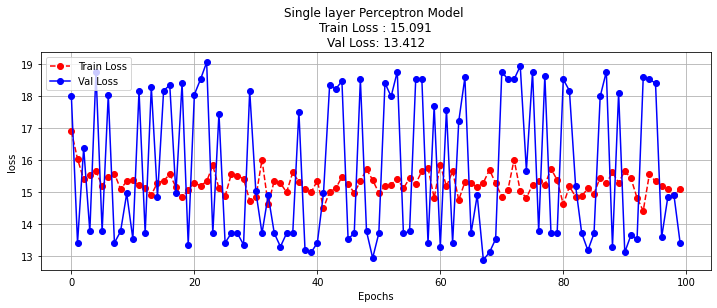

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(train_metrics_mean_row[0], '--o', color = 'red', label = 'Train Loss')
plt.plot(val_metrics_row[0], '-o', color = 'blue', label = 'Val Loss')

plt.title('Single layer Perceptron Model \nTrain Loss : {:.3f}\nVal Loss: {:.3f}'.format(train_metrics_mean_row[0][-1] , val_metrics_row[0][-1]))
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.show()